In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import optim
import torch.nn.functional as F
from graphdot import Graph
from graphdot.dataset.qm7 import QM7
from graphdot.kernel.marginalized import MarginalizedGraphKernel
from graphdot.kernel.fix import Normalization
from graphdot.metric import MaxiMin, KernelInducedDistance
from graphdot.model.active_learning import (
    HierarchicalDrafter, DeterminantMaximizer, VarianceMinimizer
)
import graphdot.microkernel as uX

/home/symfac/SymFac/venv-mpl3.4/lib/python3.8/site-packages/graphdot/graph/__init__.py:23: UserWarning: Cannot import RDKit, `graph.from_rdkit()` will be unavailable.

  warnings.warn(


In [3]:
qm7 = QM7(ase=True)

In [4]:
qm7['graph'] = qm7.atoms.apply(Graph.from_ase)

In [5]:
qm7

columb_matrix  atomization_energy  \
0     [[36.858105, 2.9076326, 2.907612, 2.9075644, 2...         -417.959991   
1     [[36.858105, 12.599944, 2.9019997, 1.4731182, ...         -712.419983   
2     [[36.858105, 14.261827, 1.503703, 2.9249973, 2...         -564.210022   
3     [[36.858105, 15.871878, 2.9794335, 1.4012247, ...         -404.880005   
4     [[73.51669, 17.885317, 10.56149, 4.355064, 2.0...         -808.869995   
...                                                 ...                 ...   
7160  [[53.358707, 9.141385, 15.175637, 7.2653837, 6...        -1919.540039   
7161  [[53.358707, 6.342397, 8.4399395, 5.742288, 19...        -1657.630005   
7162  [[36.858105, 8.569991, 13.293801, 12.611694, 1...        -1662.099976   
7163  [[36.858105, 12.540301, 8.026131, 12.617767, 8...        -1782.010010   
7164  [[36.858105, 12.629306, 12.609996, 7.9831047, ...        -1919.000000   

                                          atomic_charge  \
0     [6.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...   
1     [6.0, 6.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, ...   
2     [6.0, 6.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...   
3     [6.0, 6.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
4     [6.0, 6.0, 8.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...   
...                                                 ...   
7160  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 1.0, 1.0, ...   
7161  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 1.0, 1.0, ...   
7162  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 7.0, 1.0, 1.0, ...   
7163  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 1.0, 1.0, ...   
7164  [6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 1.0, 1.0, ...   

                                                    xyz  split  \
0     [[1.886438, -0.0046487264, -0.008239206], [3.9...      0   
1     [[1.8973607, -0.005574692, -0.012094247], [4.7...      4   
2     [[1.8692415, 0.00018897261, 0.0], [4.393462, -...      2   
3     [[1.880183, 0.0, 0.0], [4.1483455, 0.0, 0.0], ...      1   
4     [[1.9000819, -0.0012850137, 0.0081447195], [4....      4   
...                                                 ...    ...   
7160  [[4.8061213, -0.53575623, -3.0970721], [4.5876...      3   
7161  [[4.8113937, -0.41228154, -3.057917], [4.50079...      0   
7162  [[4.110022, -1.0346062, 2.6948628], [4.378571,...      1   
7163  [[1.8003232, -0.0696931, -0.22911039], [4.6702...      2   
7164  [[3.531766, 0.25823107, -1.352477], [3.4395094...      3   

                                                  atoms  \
0     (Atom('C', [1.886438012123108, -0.004648726433...   
1     (Atom('C', [1.8973606824874878, -0.00557469204...   
2     (Atom('C', [1.86924147605896, 0.00018897261179...   
3     (Atom('C', [1.8801829814910889, 0.0, 0.0], ind...   
4     (Atom('C', [1.9000818729400635, -0.00128501374...   
...                                                 ...   
7160  (Atom('C', [4.806121349334717, -0.535756230354...   
7161  (Atom('C', [4.811393737792969, -0.412281543016...   
7162  (Atom('C', [4.110022068023682, -1.034606218338...   
7163  (Atom('C', [1.800323247909546, -0.069693103432...   
7164  (Atom('C', [3.531765937805176, 0.2582310736179...   

                                                  graph  
0     Graph(nodes={'!i': [0,1,2,3,4], 'element': [6,...  
1     Graph(nodes={'!i': [0,1,2,3,4,5,6,7], 'element...  
2     Graph(nodes={'!i': [0,1,2,3,4,5], 'element': [...  
3     Graph(nodes={'!i': [0,1,2,3], 'element': [6,6,...  
4     Graph(nodes={'!i': [0,1,2,3,4,5,6,7,8], 'eleme...  
...                                                 ...  
7160  Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8...  
7161  Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8...  
7162  Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8...  
7163  Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8...  
7164  Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8...  

[7165 rows x 7 columns]

# Problem size

In [6]:
N = 256

# Marginalized Graph Kernel Matrix

In [7]:
kernel = Normalization(
    MarginalizedGraphKernel(
        node_kernel=uX.TensorProduct(element=uX.KroneckerDelta(h=0.1)),
        edge_kernel=uX.TensorProduct(length=uX.SquareExponential(length_scale=0.01)),
        q=0.001
    )
)

In [8]:
X = {}

In [9]:
%%time
# Pick random subset
X['random'] = qm7.graph.sample(N, replace=False, random_state=1285)  

CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 828 µs


In [10]:
%%time
# Pick subset that maximizes determinant
drafter = HierarchicalDrafter(
    DeterminantMaximizer(kernel, kernel_options=dict(lmin=1)),
)
X['maxdet'] = qm7.graph[drafter(qm7.graph, N, random_state=5718759812)]

CPU times: user 2min 8s, sys: 6min 2s, total: 8min 10s
Wall time: 21.6 s


In [11]:
%%time
# Pick subset that minimizes GPR posterior variance
drafter = HierarchicalDrafter(
    VarianceMinimizer(kernel, kernel_options=dict(lmin=1)),
)
X['minvar'] = qm7.graph[drafter(qm7.graph, N, random_state=578121875)]

CPU times: user 2min 58s, sys: 4min 50s, total: 7min 48s
Wall time: 15.9 s


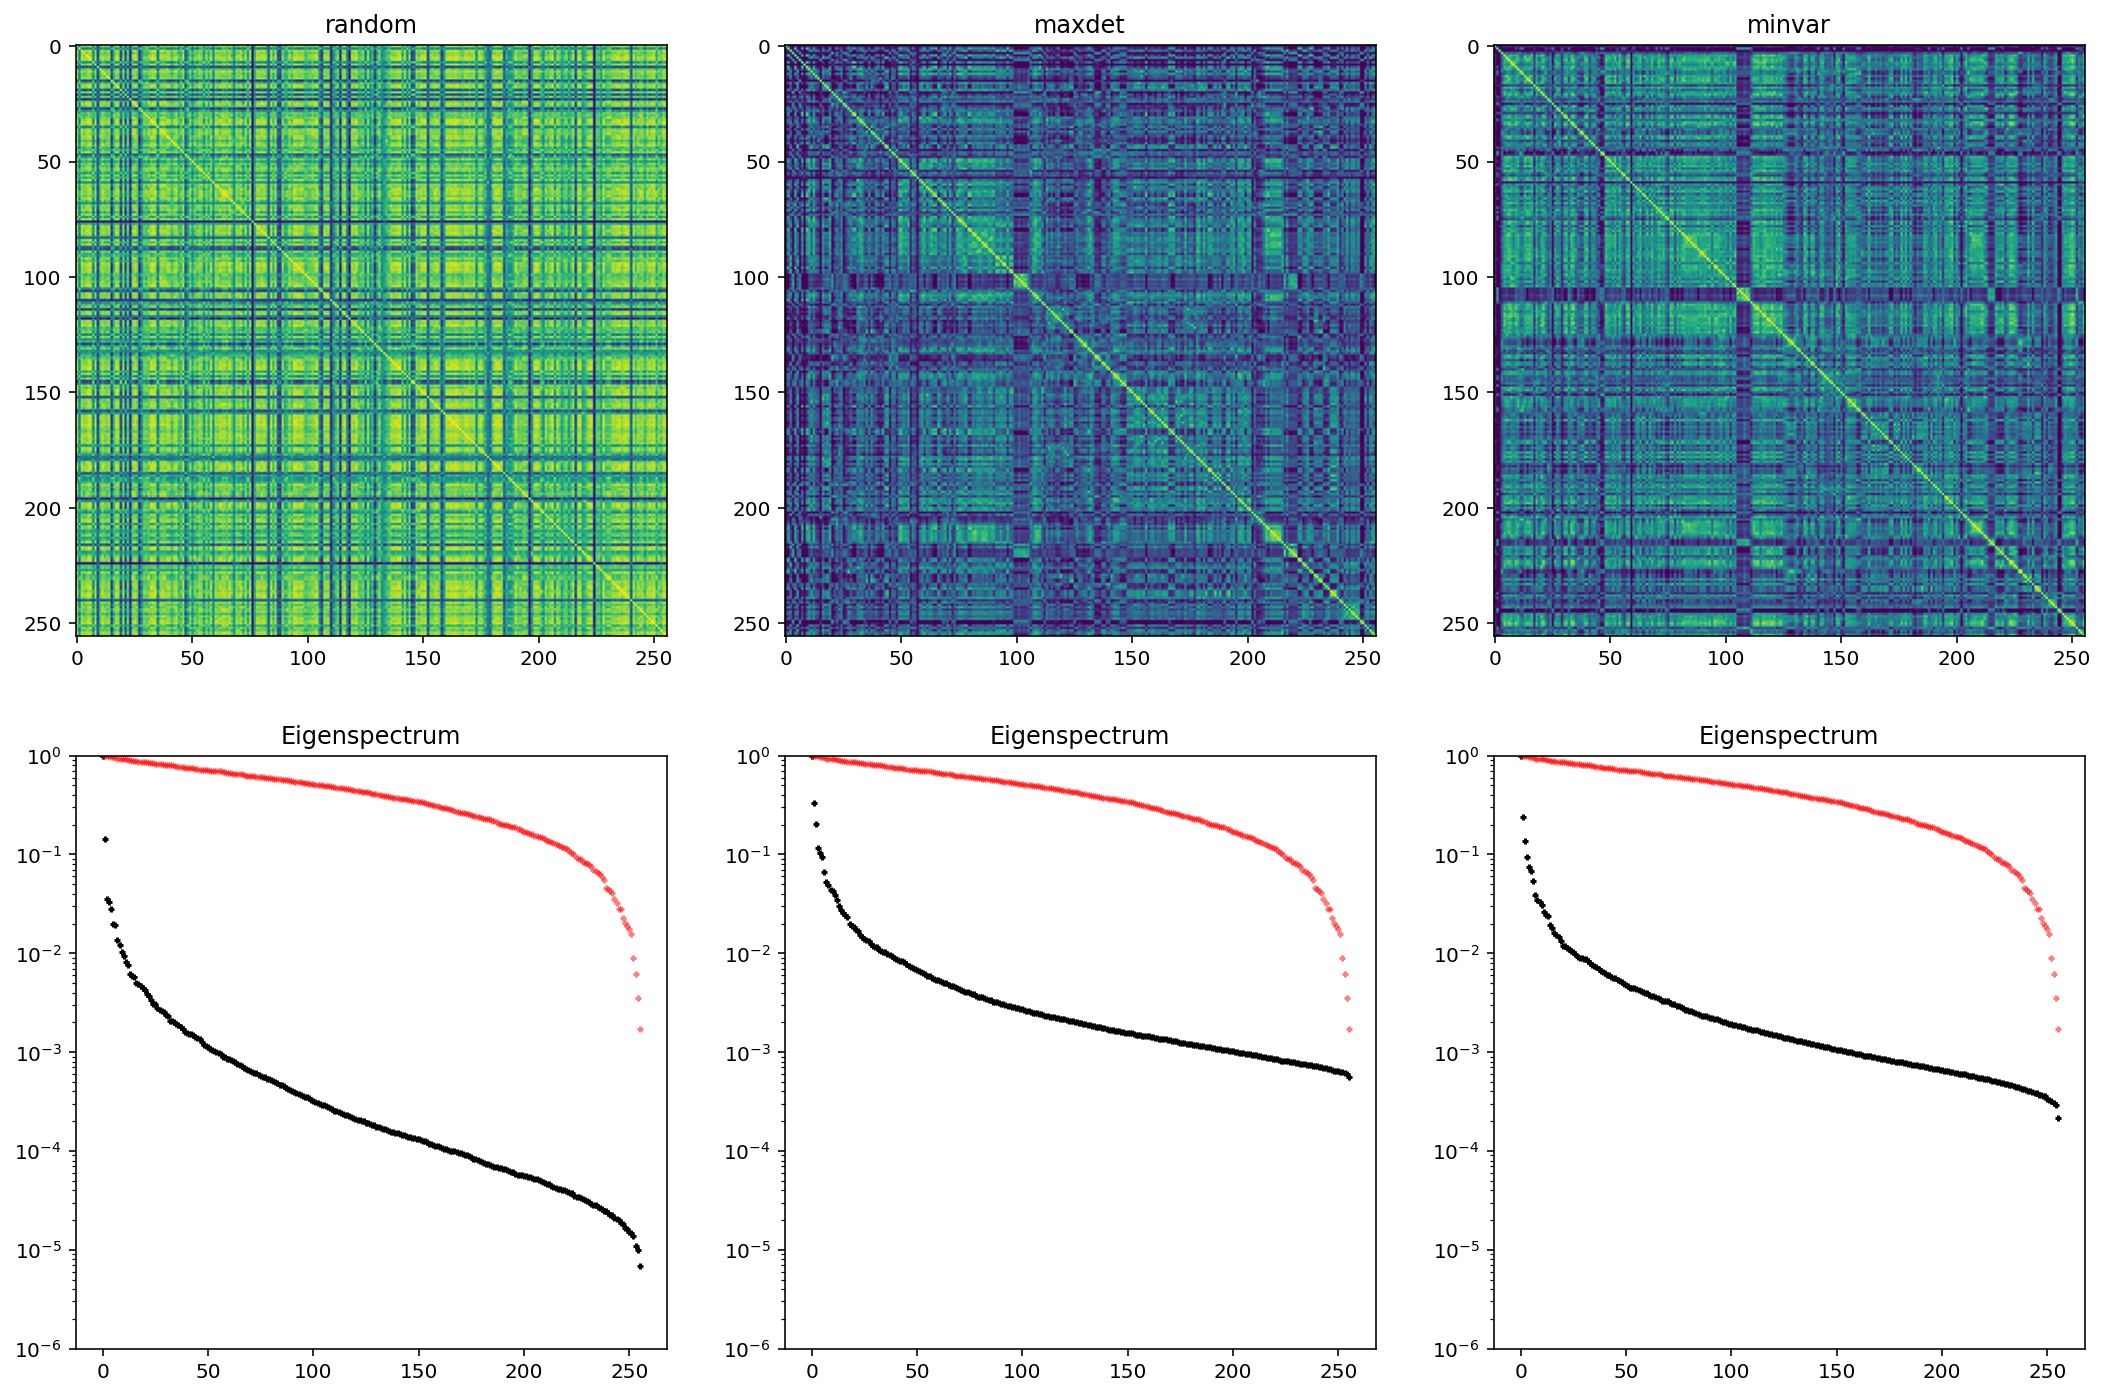

In [13]:
# random kernel matrix as a reference
G = np.random.randn(N, N)
G = 0.5 * (G + G.T)
w_ref = np.sort(np.abs(np.linalg.eigvalsh(G)))[-1::-1]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, (title, x) in enumerate(X.items()):
    K = kernel(x, lmin=1)
    np.save(f'data/paper/QM7-similarity.{title}.npy', K)
    
    w = np.linalg.eigvalsh(K)[-1::-1]
    
    axs[0, i].set_title(title)
    axs[0, i].imshow(K)
    
    axs[1, i].set_title('Eigenspectrum')
    axs[1, i].scatter(np.arange(len(w)), w / w.max(), s=8, marker='+', color='k')
    axs[1, i].scatter(np.arange(len(w_ref)), w_ref / w_ref.max(), s=8, color='r', marker='+', alpha=0.5)
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim([1e-6, 1])

plt.show()

# Marginalized Kernel's RKHS Distance

This is essentially an 'inversion' of the kernel matrix above and behaves rather similarly.

In [14]:
dist_rkhs = KernelInducedDistance(kernel, kernel_options=dict(lmin=1))

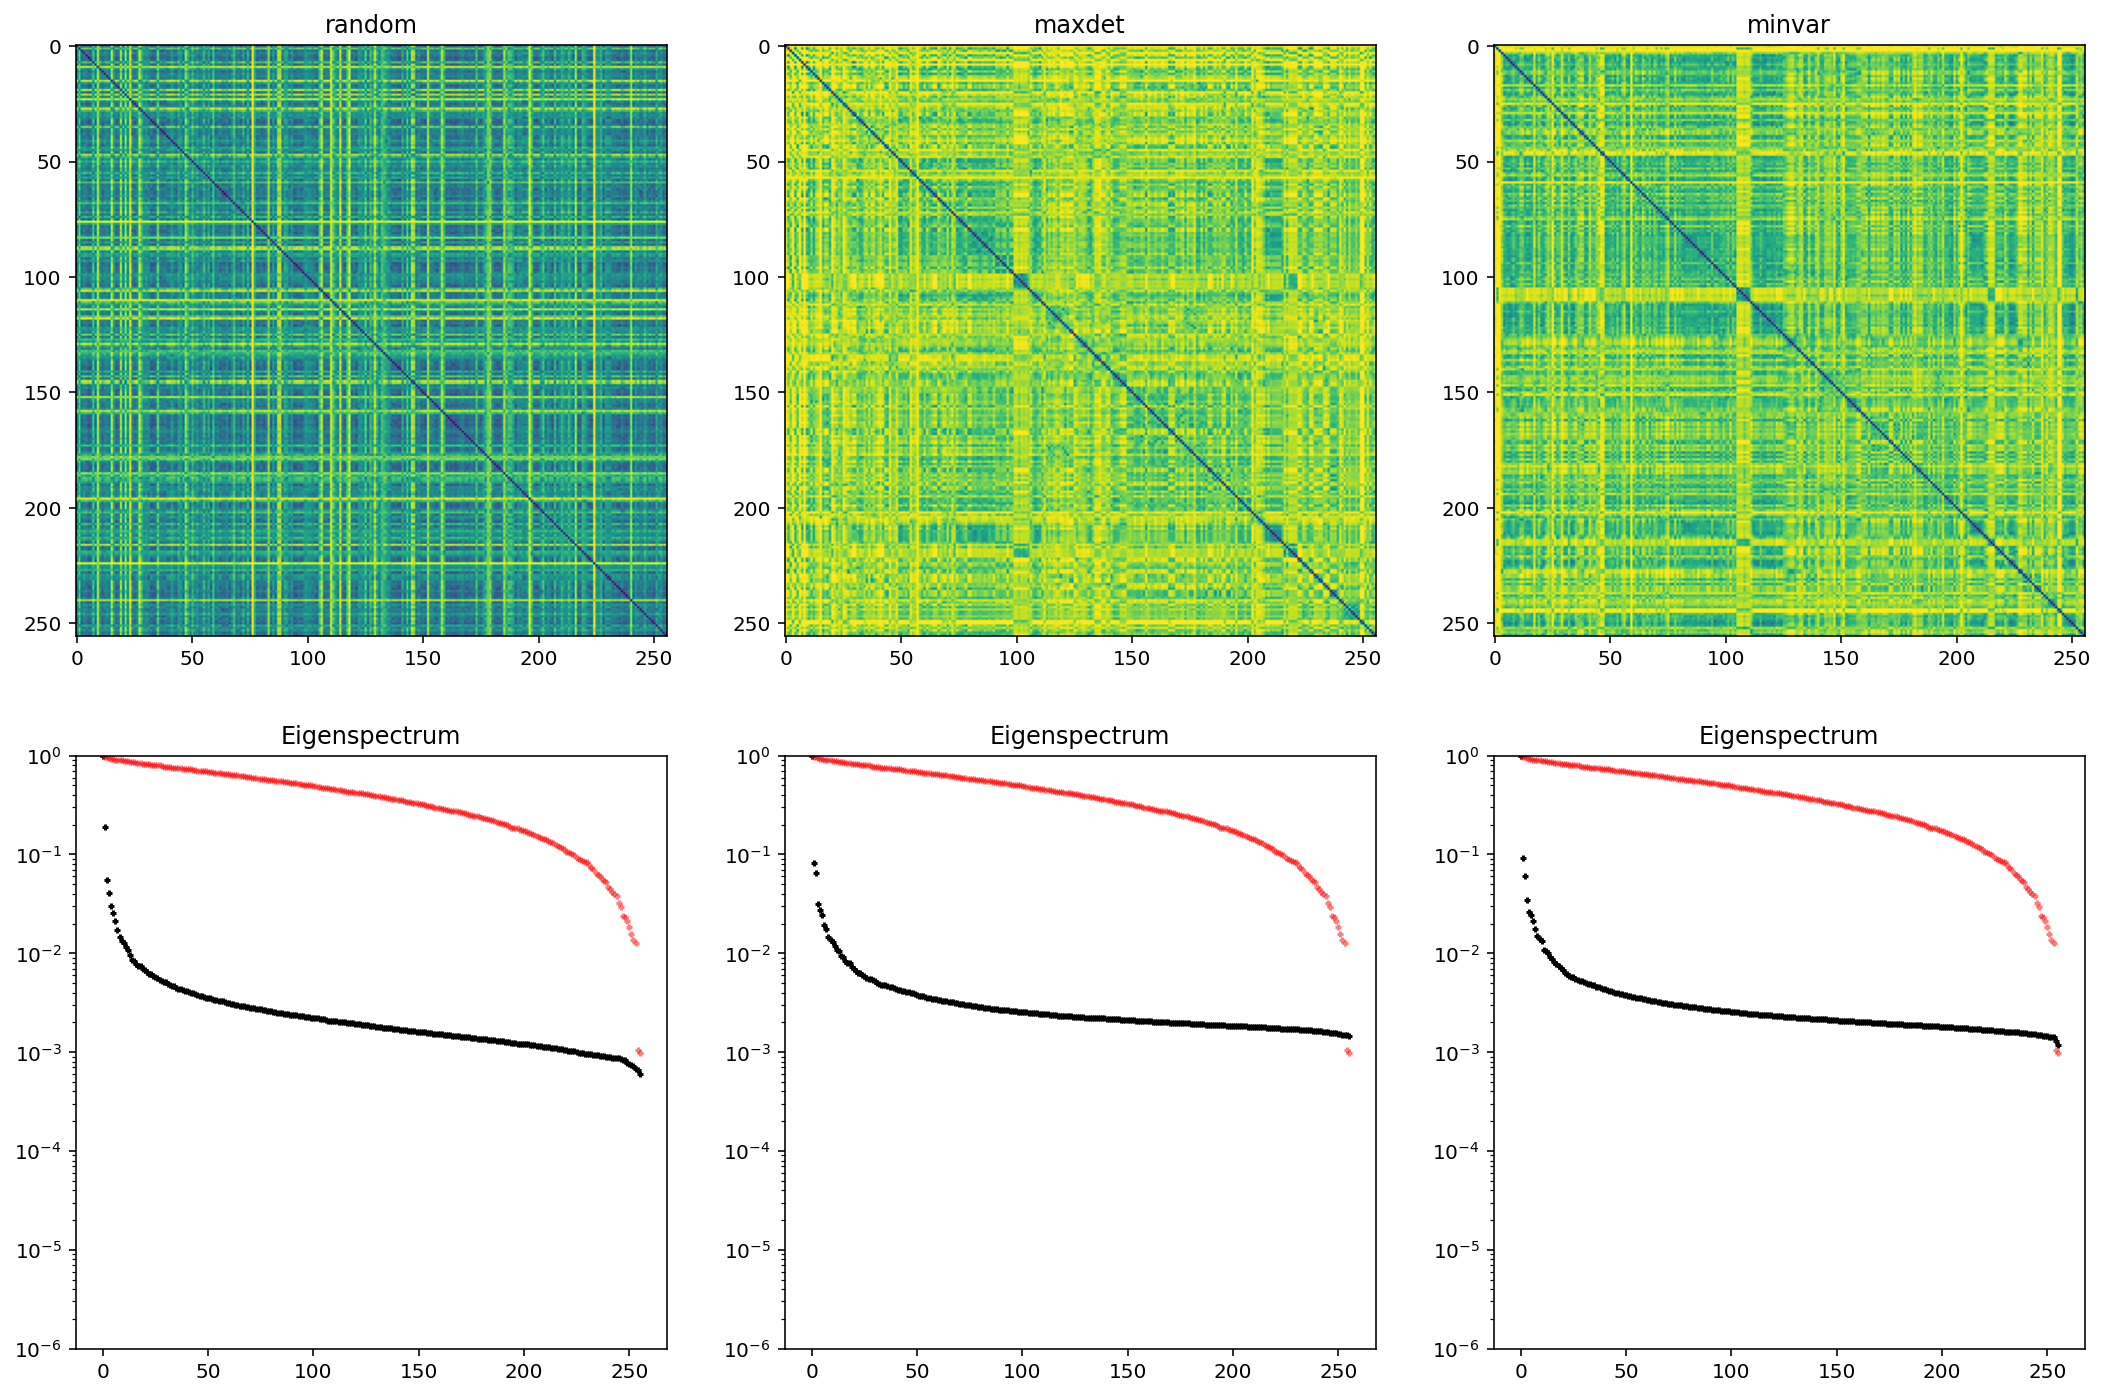

In [18]:
# random kernel matrix as a reference
G = np.random.randn(N, N)
G = 0.5 * (G + G.T)
w_ref = np.sort(np.abs(np.linalg.eigvalsh(G)))[-1::-1]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, (title, x) in enumerate(X.items()):
    D = dist_rkhs(x)
    w = np.sort(np.abs(np.linalg.eigvalsh(D)))[-1::-1]
    np.save(f'data/paper/QM7-rkhs-distance.{title}.npy', D)
    
    axs[0, i].set_title(title)
    axs[0, i].imshow(D)
    
    axs[1, i].set_title('Eigenspectrum')
    axs[1, i].scatter(np.arange(len(w)), w / w.max(), s=8, marker='+', color='k')
    axs[1, i].scatter(np.arange(len(w_ref)), w_ref / w_ref.max(), s=8, color='r', marker='+', alpha=0.5)
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim([1e-6, 1])

plt.show()

# MaxiMin Distance Matrix

This distance matrix is tricker --- it is merely a metric, and not even a norm.

In [19]:
dist_haus = MaxiMin(
    node_kernel=uX.TensorProduct(element=uX.KroneckerDelta(h=0.5)),
    edge_kernel=uX.TensorProduct(length=uX.SquareExponential(length_scale=0.2)),
    q=0.25
)

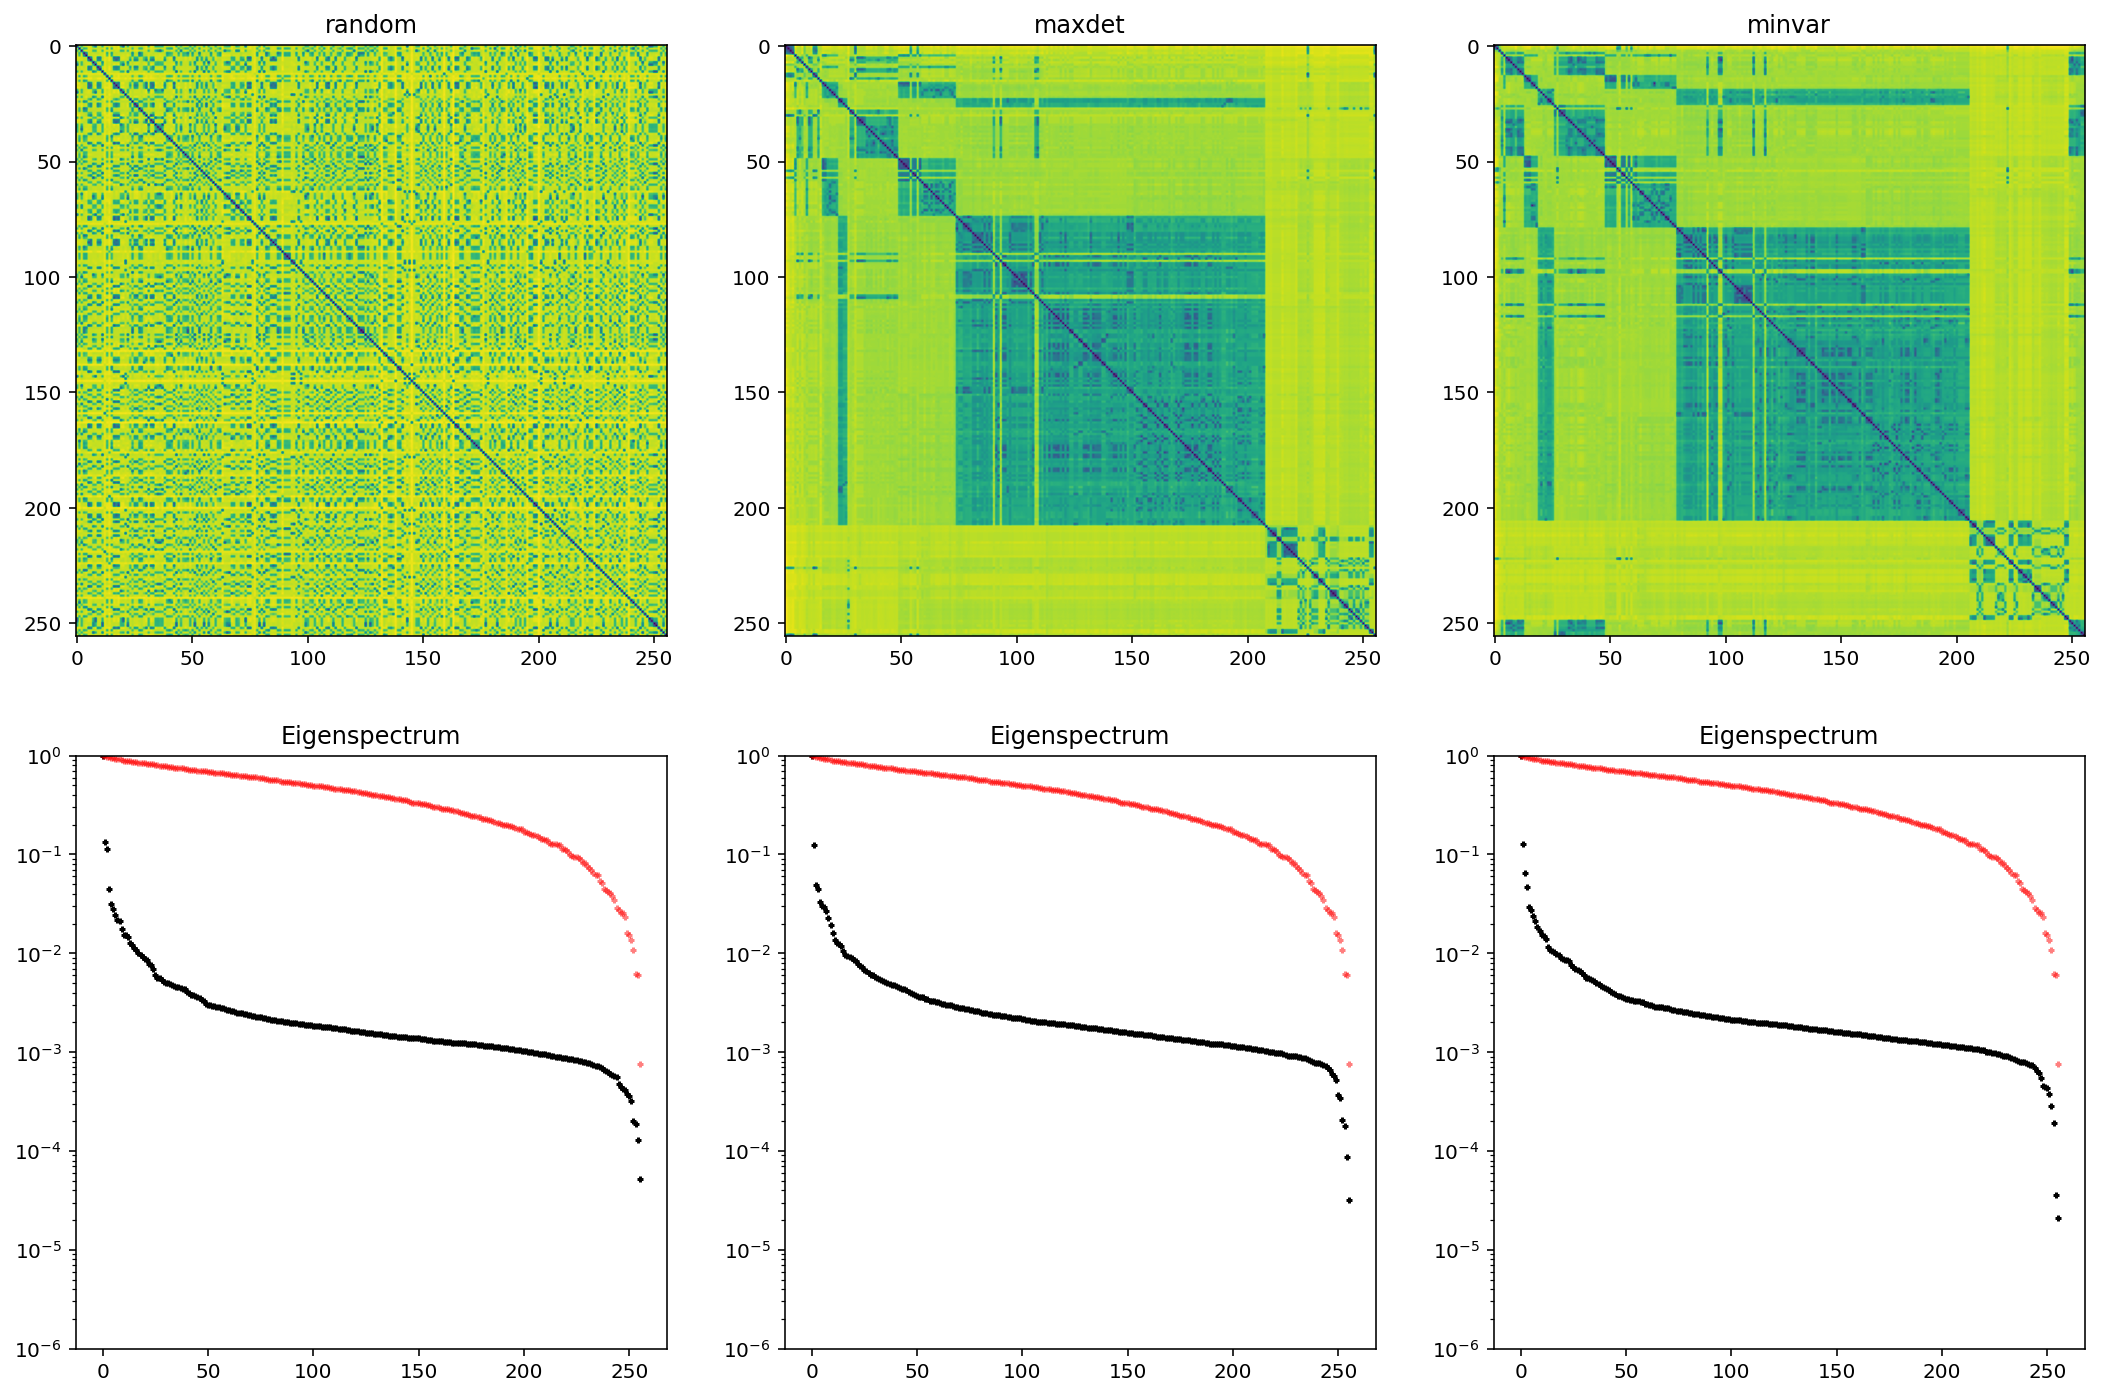

In [21]:
# random kernel matrix as a reference
G = np.random.randn(N, N)
G = 0.5 * (G + G.T)
w_ref = np.sort(np.abs(np.linalg.eigvalsh(G)))[-1::-1]

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
for i, (title, x) in enumerate(X.items()):
    D = dist_haus(x)
    w = np.sort(np.abs(np.linalg.eigvalsh(D)))[-1::-1]
    np.save(f'data/paper/QM7-maximin-distance.{title}.npy', D)
    
    axs[0, i].set_title(title)
    axs[0, i].imshow(D)
    
    axs[1, i].set_title('Eigenspectrum')
    axs[1, i].scatter(np.arange(len(w)), w / w.max(), s=8, marker='+', color='k')
    axs[1, i].scatter(np.arange(len(w_ref)), w_ref / w_ref.max(), s=8, color='r', marker='+', alpha=0.5)
    axs[1, i].set_yscale('log')
    axs[1, i].set_ylim([1e-6, 1])

plt.show()

END
-----